<a href="https://colab.research.google.com/github/Wenjie0o0/class/blob/main/Homework02_111C52024_%E6%9E%97%E6%B1%B6%E6%BD%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業2-利用課程給的人臉資料庫，訓練一個人臉偵測模型
[人臉資料庫](https://drive.google.com/file/d/1J4hTnNmrzp-xhzMx4Oh1O7MQ3PGtvyMK/view)


### 寫一個簡易的人臉偵測模型，以課程介紹boxv2(預設人臉x,y,h,w)方式預測一個人臉即可。
1. 模型大小(onnx)請控制在20MB以下。
2. 繳交訓練程式碼(ipynb)，需寫註解。
3. 繳交模型onnx。
4. 提交Inference程式碼(ipynb)，後處理請自己寫，程式請寫註解，用onnxruntime執行，檔案位置留空給助教。
測試會以老師的照片測試，五張，偵測的到就給過。
範例圖如下。



In [ ]:
import warnings
warnings.simplefilter("ignore")
import os
import random
import math
from datetime import datetime
from collections import Counter
import numpy as np
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import cv2
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from torchvision import transforms
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#資料庫讀取
labelmap = {'background':0, 'face': 1}
images_path = Path('/content/drive/MyDrive/datasets/FaceDetection/images')
anno_path = Path('/content/drive/MyDrive/datasets/FaceDetection/VOC')
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
def xml_parser(xml_path):
    root = ET.parse(xml_path).getroot()
    filename = Path(str(images_path) + '/' + root.find("./filename").text)
    bboxes=[]
    labels=[]
    for object_xml in root.iter('object'):
        label = object_xml.find('name').text.lower()
        bbox = object_xml.find('bndbox')
        xmin = int(bbox.find("xmin").text) 
        ymin = int(bbox.find("ymin").text) 
        xmax = int(bbox.find("xmax").text) 
        ymax = int(bbox.find("ymax").text) 
        bbox = [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)
        labels.append(labelmap[label])
    return filename, bboxes, labels

def generate_data_inf(annotations):
    imagepaths = []
    bboxes = []
    for anno_path in annotations:
        filename, bboxs, labels = xml_parser(anno_path)
        imagepaths.append(filename)
        bboxes.append([labels,bboxs])
    return imagepaths, bboxes

annotations = filelist(anno_path, '.xml')
imagepaths, bboxes = generate_data_inf(annotations)

In [ ]:
background_path = Path('/content/drive/MyDrive/datasets/FaceDetection/background')
imagepaths_background = filelist(background_path, '.jpg')
bboxes_ground=[]
for i in imagepaths_background:
    bboxes_ground.append([[0], [[0,0,0,0]]])
imagepaths+=imagepaths_background
bboxes+=bboxes_ground

In [ ]:
def plot_image_withbbox(img, bboxs, labels=[], flag_bgr=1):
    imageplot=img.copy()
    if len(labels)==0:
        for bb in bboxs:
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
    else:
        for bb, label in zip(bboxs,labels):
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
            cv2.putText(imageplot, str(label), (int(bb[0]),int(bb[1])), 0, 1, (200, 0, 255), 4, cv2.LINE_AA)
    if flag_bgr==1:
        plt.imshow(cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB))
    else:
         plt.imshow(imageplot)
    plt.show()

In [ ]:
#模型架構
class objectdetection_model(nn.Module):
    def __init__(self, n_class, n_bbox):
        super(objectdetection_model, self).__init__()
        resnet = models.resnet18(pretrained=True)
        #layers = list(resnet.children())[:8]
        layers = list(resnet.children())[:7]   #將原本的8改成7可以有效降低大小且準確率不會下降太多
        self.features = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        #self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, n_bbox*(n_class+1)))
        #self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, n_bbox * 4))
        self.classifier = nn.Sequential(nn.BatchNorm1d(256), nn.Linear(256, n_bbox*(n_class+1))) #因為層數設定改成7所以輸入通道也要從512改成256
        self.bb = nn.Sequential(nn.BatchNorm1d(256), nn.Linear(256, n_bbox * 4))
       
    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = self.flatten(x)
                                                  
        return self.classifier(x), self.bb(x)

In [ ]:
#將資料分成訓練集和測試集
n_data = len(imagepaths)
val_size = 0.2
n_val = int(n_data * val_size)
n_train = n_data - n_val
np.random.seed(20210626)
randorder = np.random.permutation(n_data)

data_train = [imagepaths[randorder[tmp]]for tmp in range(n_train)]
bboxes_train = [bboxes[randorder[tmp]]for tmp in range(n_train)]
data_val = [imagepaths[randorder[tmp]]for tmp in range(n_train, n_data)]
bboxes_val = [bboxes[randorder[tmp]]for tmp in range(n_train, n_data)]
print('number of training data:{}'.format(len(data_train)))
print('number of validation data:{}'.format(len(data_val)))
print('number of total data:{}'.format(n_data))

number of training data:471
number of validation data:117
number of total data:588


In [ ]:
def count_object(bboxes):
    n_object=np.zeros(2)
    for boxs in bboxes:
        if len(boxs[0])>2:
            for box in boxs[0]:
                n_object[box]+=1
        else:
            n_object[boxs[0]]+=1
    print(n_object)
print('number of object in training set:')
count_object(bboxes_train)
print('number of object in validation set:')
count_object(bboxes_val)

number of object in training set:
[ 25. 446.]
number of object in validation set:
[  5. 112.]


original image


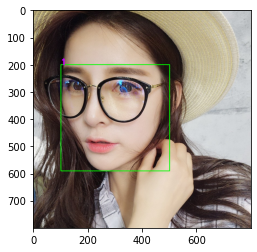

resized image


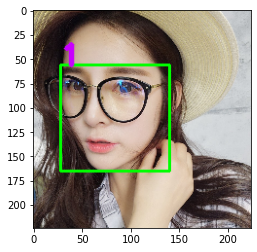

zoom_out image


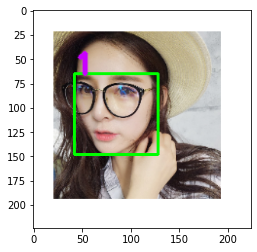

In [ ]:
#定義Dataloader 與 data transforms
def resizewithbbox(image, bboxes, newsize=[224,224]): #將圖片的大小轉換為224*224，對應的BBOX也跟著轉換
    image = np.array(image)
    h,w,ch = image.shape
    new_w, new_h = newsize[0], newsize[1]
    scale_h, scale_w = new_h/h, new_w/w
    new_image = cv2.resize(image, (new_w, new_h))
    new_image = Image.fromarray(new_image)
    n = len(bboxes)
    new_bboxes = np.array(bboxes)
    
    if n:
        new_bboxes[:, 0] = new_bboxes[:, 0]*scale_w 
        new_bboxes[:, 1] = new_bboxes[:, 1]*scale_h 
        new_bboxes[:, 2] = new_bboxes[:, 2]*scale_w 
        new_bboxes[:, 3] = new_bboxes[:, 3]*scale_h 
    return new_image, new_bboxes

def zoom_out(image, bboxes):
    image = np.array(image)
    h,w,ch = image.shape
    img_aug = np.ones(image.shape,dtype=np.int8)*255
    
    ratio = np.random.choice([1.05,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9, 2])
    new_w = int(w/ratio)
    new_h = int(h/ratio)
    
    new_img, new_bboxes = resizewithbbox(image, bboxes, [new_w,new_h])

    new_img = np.array(new_img)
    remain_w = w - new_w
    remain_h = h - new_h
    if (remain_w>int(w/4))&(remain_h>int(h/4)):
        st_w = np.random.randint(int(w/4), remain_w)
        st_h = np.random.randint(int(h/4), remain_h) 
    else:
        st_w = np.random.randint(0, remain_w)
        st_h = np.random.randint(0, remain_h)
    
    
    img_aug[st_h:st_h+new_h, st_w:st_w+new_w,:]=new_img
    
    img_aug = Image.fromarray(np.uint8(img_aug))
    
    n = len(new_bboxes)
    new_bboxes = np.array(new_bboxes)
    if n:
        new_bboxes[:, 0] = new_bboxes[:, 0]+st_w  
        new_bboxes[:, 1] = new_bboxes[:, 1]+st_h
        new_bboxes[:, 2] = new_bboxes[:, 2]+st_w  
        new_bboxes[:, 3] = new_bboxes[:, 3]+st_h 
    return img_aug, new_bboxes

for image_id in [176]:    
    image_path = data_train[image_id]
    bboxes = bboxes_train[image_id][1]
    labels = bboxes_train[image_id][0]
    print('original image')
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    imageplot=np.array(img.copy())
    plot_image_withbbox(imageplot, bboxes, labels,flag_bgr=0)

    print('resized image')
    new_img, new_bboxes = resizewithbbox(img, bboxes)
    imageplot=np.array(new_img.copy())
    plot_image_withbbox(imageplot, new_bboxes, labels,flag_bgr=0)
    
    print('zoom_out image')
    new_img, new_bboxes = zoom_out(new_img, new_bboxes)
    imageplot=np.array(new_img.copy())
    plot_image_withbbox(imageplot, new_bboxes, labels,flag_bgr=0)

In [ ]:
# image pre-process
process_transforms = transforms.Compose([
    transforms.ToTensor(),   #將8bits RGB PIL格式圖片(0-255)直接除上255轉換成(0-1)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])   #將圖片進行正規化(Z-socre)
    ]
)
transforms_dataaug = transforms.ColorJitter(brightness=(0.5, 1.5),    #進行資料擴增
                       contrast=(0.5, 1.5), 
                       saturation=(0.5, 1.5), 
                       hue=(-18/255, 18/255))

class FaceDatasetv2(Dataset):
    def __init__(self, image_paths, bboxes, newsize=[224,224], is_transforms=False):
        self.is_transforms = is_transforms   #如果是training phase則需要做Data Augumentation
        self.image_paths = image_paths
        self.bboxes = bboxes
        self.newsize=newsize
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        bboxes = self.bboxes[idx]
        
        # 1.
        img = Image.open(path, mode='r')
        img = img.convert('RGB')
        bboxs = bboxes[1]
        bboxs_class = bboxes[0]
                
        # 2.
        img, bboxs = resizewithbbox(img, bboxs, newsize=self.newsize)

        # 3. 
        if self.is_transforms:
            if np.random.random()<0.3:
                img, bboxs = zoom_out(img, bboxs)
        if self.is_transforms:
            if np.random.random()<0.3:
                img = transforms_dataaug(img)
                
        img = process_transforms(img)
        bboxs_class= torch.tensor(bboxs_class)
        
        # 4.
        bboxs = bboxs/self.newsize[0]
        xs= bboxs[:,0] + (bboxs[:,2]-bboxs[:,0])/2
        ys= bboxs[:,1] + (bboxs[:,3]-bboxs[:,1])/2
        ws= bboxs[:,2]-bboxs[:,0]
        hs= bboxs[:,3]-bboxs[:,1]
            
        bboxs= np.zeros(bboxs.shape)
        bboxs[:,0] = xs
        bboxs[:,1] = ys
        bboxs[:,2] = ws
        bboxs[:,3] = hs
        bboxs = torch.FloatTensor(bboxs)
#         bboxs = torch.FloatTensor(bboxs/self.newsize[0])
        return img, bboxs, bboxs_class
    
    def collate_fn(self, batch):
        imgs = list()
        bboxes = list()
        bboxes_class = list()
        for b in batch:
            imgs.append(b[0])
            bboxes.append(b[1])
            bboxes_class.append(b[2])
        imgs=torch.stack(imgs,dim=0)
        return imgs, bboxes, bboxes_class

In [ ]:
class LOSS_OD(nn.Module):
    def __init__(self, n_bbox, n_class):
        super(LOSS_OD,self).__init__()
        self.n_bbox = n_bbox
        self.n_class = n_class
        self.Softmax= nn.Softmax(dim=2)
    def forward(self,preds_bb, preds_class, bboxs, bboxs_class):
        # preds_bb:  n_batch * (n_bbox*4 =24)
        # preds_class: n_batch * (n_bbox*(n_class+1)= 30)
        # bboxs: batch * n_object * 4
        # bboxs_class: batch * n_object 
        n_bbox = self.n_bbox
        n_class = self.n_class
        batch_size = preds_bb.size(0)
        
        preds_class = torch.reshape(preds_class,(batch_size, n_bbox, n_class+1)) # (batch, n_bbox, n_class+1)
        preds_class = self.Softmax(preds_class)
        preds_bb = torch.reshape(preds_bb,(batch_size, n_bbox, 4)) # (batch, n_bbox, 4)

        loss_conf,  loss_locs = 0,0
        for b in range(batch_size):
            sub_bboxs = bboxs[b]
            sub_bboxs_class = bboxs_class[b]
            n_object = sub_bboxs.size(0)
            
            if n_object==0:
                continue        
            pred_class=preds_class[b,0:n_object,:] # n_object=1
            pred_bb=preds_bb[b,0:n_object,:]
            
            loss_conf +=  F.cross_entropy(pred_class.view(-1,n_class+1),sub_bboxs_class , reduction="sum")
            loss_locs += F.l1_loss(pred_bb, sub_bboxs, reduction="sum")
        return 2*loss_locs + loss_conf

In [ ]:
use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
epochs = 200   #從50改成200
n_class = 1
n_bbox = 1 # 模型要最多能預測多少物件
lr = 0.001
batch_size = 32

# training -> is_transforms=True
# validation/test -> is_transforms=False
dataset_train = FaceDatasetv2(data_train, bboxes_train, newsize=[224,224], is_transforms=True) 
dataset_val   = FaceDatasetv2(data_val,   bboxes_val,   newsize=[224,224], is_transforms=False) 
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=dataset_train.collate_fn)
valid_dl = DataLoader(dataset_val  , batch_size=batch_size, shuffle=True, collate_fn=dataset_val.collate_fn)


#checkpoint = torch.load('Model_facedetection_withbackground_augZoomOut.pth')
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)
#print(model)
#model.load_state_dict(checkpoint['model_dict'])

loss_od = LOSS_OD(n_bbox=n_bbox, n_class=n_class)

# params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
import time
loss_train_log, loss_val_log=[],[]
loss_all_train_log, loss_all_val_log=[],[]
for e in range(epochs):
    # training step
    model.train()
    total, sum_loss = 0, 0
    st=time.time()
    c=0
    for imgs, bboxs, bboxs_class in train_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        preds_class, preds_bb = model(imgs)
        loss = loss_od(preds_bb, preds_class, bboxs, bboxs_class)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len_batch
        sum_loss += loss.item()
        loss_all_train_log.append(loss.item())
        
        c+=1
    time_train =  time.time()-st
    train_loss = sum_loss / total
    loss_train_log.append(train_loss)
    
    # eval
    model.eval()
    total, sum_loss = 0, 0
    st=time.time()
    for imgs, bboxs, bboxs_class in valid_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        with torch.no_grad():
            preds_class, preds_bb = model(imgs)
            loss = loss_od(preds_bb, preds_class, bboxs, bboxs_class)
            
        total += len_batch
        sum_loss += loss.item()
        loss_all_val_log.append(loss.item())
    time_val =  (time.time()-st) 
    eval_loss = sum_loss / total
    loss_val_log.append(eval_loss)
    if e % 5 == 0:
        print("Epoch[{}/{}], lr={:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, train_time:{:.4f},val_time:{:.4f}".format(e+1,
                                                                                                               epochs,
                                                                                                               scheduler.get_last_lr()[0],
                                                                                                               train_loss, 
                                                                                                               eval_loss,
                                                                                                               time_train,
                                                                                                               time_val))
    scheduler.step()

Epoch[1/200], lr=0.001000, train_loss: 5.0352, val_loss: 3.7151, train_time:9.4103,val_time:1.7021
Epoch[6/200], lr=0.001000, train_loss: 1.3116, val_loss: 1.3102, train_time:8.9881,val_time:1.6963
Epoch[11/200], lr=0.000100, train_loss: 0.8693, val_loss: 0.8976, train_time:8.8346,val_time:1.7482
Epoch[16/200], lr=0.000100, train_loss: 0.7415, val_loss: 0.8597, train_time:8.8064,val_time:1.6631
Epoch[21/200], lr=0.000010, train_loss: 0.7049, val_loss: 0.7994, train_time:8.7785,val_time:1.6983
Epoch[26/200], lr=0.000010, train_loss: 0.6825, val_loss: 0.7974, train_time:8.9769,val_time:1.6534
Epoch[31/200], lr=0.000001, train_loss: 0.6937, val_loss: 0.7969, train_time:8.8061,val_time:1.6766
Epoch[36/200], lr=0.000001, train_loss: 0.6736, val_loss: 0.8042, train_time:11.7088,val_time:1.7139
Epoch[41/200], lr=0.000000, train_loss: 0.6787, val_loss: 0.7980, train_time:9.0815,val_time:1.7033
Epoch[46/200], lr=0.000000, train_loss: 0.6903, val_loss: 0.7991, train_time:8.9564,val_time:1.6616
E

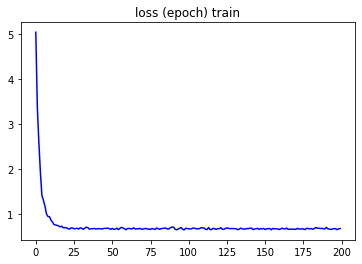

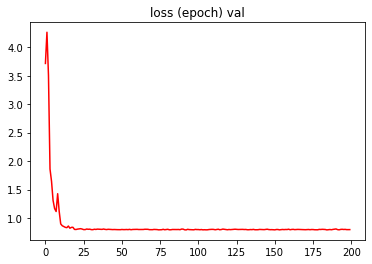

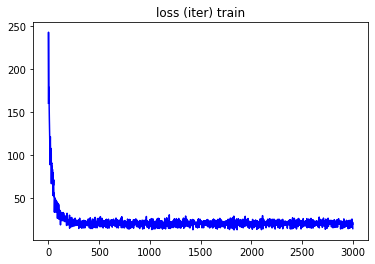

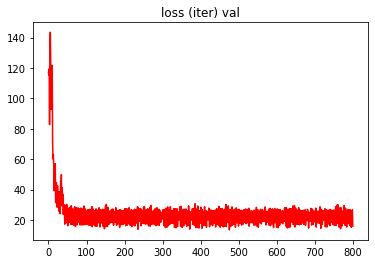

In [ ]:
plt.plot(loss_train_log[:],'b')
plt.title('loss (epoch) train')
plt.show()

plt.plot(loss_val_log[:],'r')
plt.title('loss (epoch) val')
plt.show()

plt.plot(loss_all_train_log[:],'b')
plt.title('loss (iter) train')
plt.show()

plt.plot(loss_all_val_log[:],'r')
plt.title('loss (iter) val')
plt.show()

In [ ]:
checkpoint={}
checkpoint['loss_train_log']=loss_train_log
checkpoint['loss_val_log']=loss_val_log
checkpoint['loss_all_train_log']=loss_all_train_log
checkpoint['loss_all_val_log']=loss_all_val_log
checkpoint['model_dict'] = model.state_dict()
torch.save(checkpoint, 'Model_facedetection_v2.pth')
print('Model saved.')

Model saved.


In [ ]:
#模型測試
# load model
use_cuda = 1
n_class = 1
n_bbox = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
checkpoint = torch.load('Model_facedetection_v2.pth')
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)
model.load_state_dict(checkpoint['model_dict'])


<All keys matched successfully>

Inference Image:/content/drive/MyDrive/datasets/FaceDetection/images/002021041323355210105.jpg
original image


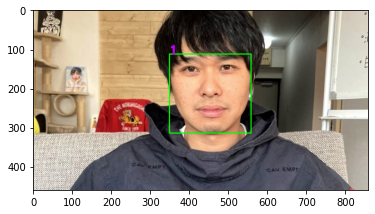

Detection image
[[ 91  54 145 152]]
[[ 96.756386  48.942154 154.6413   162.2128  ]]


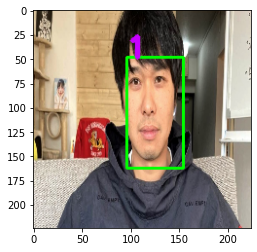

Inference Image:/content/drive/MyDrive/datasets/FaceDetection/images/closeup_view_of_auburn_hair_avril_lavigne_gir_model_4k_hd_girls-1280x720.jpg
original image


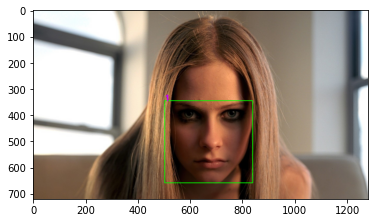

Detection image
[[ 88 107 146 204]]
[[ 98.41442  70.66382 148.55875 166.53012]]


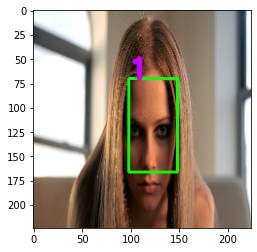

Inference Image:/content/drive/MyDrive/datasets/FaceDetection/images/048cb9da8da67d890825e534e09a0edc.jpg
original image


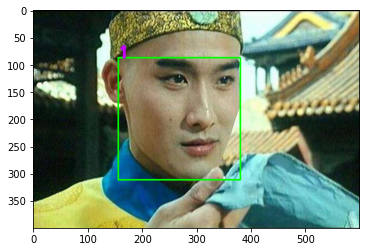

Detection image
[[ 58  48 141 174]]
[[ 43.66183   59.456757 136.817    190.87074 ]]


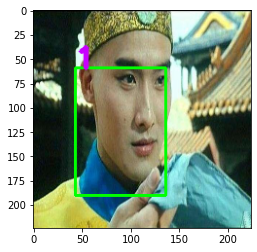

Inference Image:/content/drive/MyDrive/datasets/FaceDetection/images/portrait-einer-jungen-frau-die-nach-links-schaut-24328020.jpg
original image


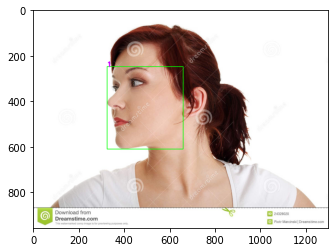

Detection image
[[ 56  58 113 142]]
[[ 58.661263  53.27682  108.509415 130.4299  ]]


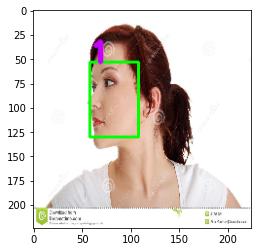

Inference Image:/content/drive/MyDrive/datasets/FaceDetection/images/rnm.jpg
original image


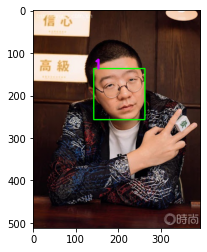

Detection image
[[ 80  59 148 112]]
[[ 80.35364   63.360435 156.20245  117.49166 ]]


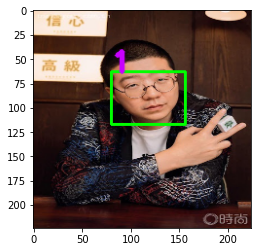

Inference Image:/content/drive/MyDrive/datasets/FaceDetection/images/istockphoto-802648974-612x612.jpg
original image


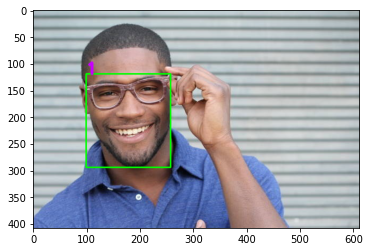

Detection image
[[ 36  65  94 161]]
[[ 54.843025  62.834564 111.88695  150.94049 ]]


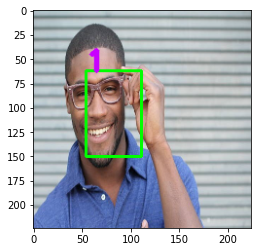

In [ ]:
for image_id in [1,10,20,30,40,50]:
    image_path = data_train[image_id]
    bboxs = bboxes_train[image_id][1]
    bboxs_class = bboxes_train[image_id][0]
    # image_path = data_val[image_id]
    # bboxs = bboxes_val[image_id][1]
    # bboxs_class = bboxes_val[image_id][0]
    print('Inference Image:{}'.format(image_path))
    print('original image')
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    imageplot=np.array(img.copy())
    plot_image_withbbox(imageplot, bboxs, bboxs_class, flag_bgr=0)


    print('Detection image')
    img, bboxs = resizewithbbox(img, bboxs,newsize=[224,224])
    resize_img=np.array(img.copy())
    img = process_transforms(img) # 3*224*224
    img = img.unsqueeze(dim=0)#  1 * 3*224*224

    model.eval()
    with torch.no_grad():
        preds_class, preds_bb = model(img.to(device)) # batch*3*224*224


    preds_bb = preds_bb[0]
    preds_bb = torch.reshape(preds_bb,(n_bbox, 4)) # (batch, n_bbox, 4)
    preds_bb = preds_bb.detach().cpu().numpy()
    
    w_half = preds_bb[:,2]/2
    h_half = preds_bb[:,3]/2
    x_min = preds_bb[:,0]-w_half
    y_min = preds_bb[:,1]-h_half
    x_max = preds_bb[:,0]+w_half
    y_max = preds_bb[:,1]+h_half
    preds_bb[:,0]=x_min
    preds_bb[:,1]=y_min
    preds_bb[:,2]=x_max
    preds_bb[:,3]=y_max
    preds_bb = preds_bb*224
    
    print(bboxs)
    print(preds_bb)

    preds_class = preds_class[0]
    preds_class = torch.reshape(preds_class,(n_bbox, n_class+1)) # ( n_bbox, n_class+1)
    preds_class = nn.Softmax(dim=1)(preds_class)
    v, ind = torch.max(preds_class,dim=1)
    v = v.detach().cpu().numpy()
    ind = ind.detach().cpu().numpy()
    p_bbox, final_bbox=[],[]
    final_label=[]
    for i,tmp_ind in enumerate(ind):
        if tmp_ind > 0:
            p_bbox.append(preds_class[i,tmp_ind])
            final_bbox.append(preds_bb[i,:])
            final_label.append(tmp_ind)
    plot_image_withbbox(resize_img, final_bbox,final_label, flag_bgr=0)


# Note: 物件對應表在前面定義在 labelmap = {'background':0, 'trafficlight': 1, 'speedlimit': 2, 'crosswalk': 3, 'stop': 3}

In [ ]:
use_cuda = 1
n_class = 1
n_bbox = 1
device = torch.device("cpu")
checkpoint = torch.load('Model_facedetection_v2.pth')
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)
model.load_state_dict(checkpoint['model_dict'])
model.eval()
dummpy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(model, 
        dummpy_input, 
        'Model_facedetection_v2.onnx', 
        opset_version=11)

In [ ]:
#!pip install onnxruntime
#!pip install onnxruntime-gpu
import onnxruntime 
import numpy as np
img_path="/content/drive/MyDrive/My Drive/datasets/FaceDetection/test/test1.jpg"
session = onnxruntime.InferenceSession("/content/Model_facedetection_v2.onnx",providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print(input_name,session.get_inputs()[0].shape)
print("------------")
print(output_name,session.get_outputs()[0].shape)

x_test=cv2.imread(img_path)
x_test=cv2.cvtColor(x_test,cv2.COLOR_BGR2RGB)

result = session.run([output_name], {input_name:x_test.astype(np.float32)})

input.1 [1, 3, 224, 224]
------------
158 [1, 2]


InvalidArgument: ignored